# Vision Transformer
Step-by-step explanation of Vision Transformer Architecture
1. Image to patches
2. Patch EMbedding
3. Add positional Embeddings
4. Add [CLS] token
5. Transformer Encoder Layers
6. Classification Head

##### 1. Image to Patches
Segment image into patches/grids (fixed-size like 4x4 or 16x16). Because this process is equivalent to the process of tokenization in NLP models (segement a sequence of text into tokens).

##### 2. Patch Embedding
Flatten the patches into 1D vector (because transformer deals with 1D data)

##### 3. Add positional Embeddings
We pass the vectors to the embedding layer to map these vectors/patches into high dimension dense vectors and then we add positional embeddings to preserve the order of the patches in order to encode positional information.

##### 4. Add [CLS] Token
CLS Token is a special learnable token or vector that represents the whole image and this CLS Token will be used for classification. The output of this CLS token will be used later on for classification. [Patch token + Patch Embedding]. Special token to summarize image.

##### 5. Transformer Encoder Layers
Consist of numerous blocks. Pass the output of [Patch token + Patch embedding] to the encoder layer.

##### 6. Classification Head
Pass the output of transformer to the classification head to classify it into predefined classes. For example....CIFAR 10 (trained) will result output in either of 10 classes (one probability value of each class and highest probability is chosen using the arg max function to choose the predicted class).

#### Comparative Study
| NLP Transformer | Vision Transformer (VIT) | Explanation |
| --- | --- | --- |
| Tokens | Patches | Words/subwords in text -> Image split into small fixed-size patches |
| Token IDs| Patch Indices | Each patch can be indexed like tokens |
| Token Embedding | Patch Embedding | Converts token/patch index into dense vectors via learned projection |
| Positional Embedding | Positional Embedding | Adds location information for sequence order/spatial structure |
| [CLS] Token | [CLS] Token | Special token to summarize sequence/image -> used for classification |
| Encoder Input Sequence | Embedded Patch Sequence | Input to Transformer: tokens + positional encoding OR patches + positional info |
| Transformer Encoder Layers | Transformer Encoder Layers | Identical architecture for modeling dependencies |
| Output Token Representation | [CLS] Token Representation | Used to generate final prediction (e.g., class label) |
| Softmax Layer | Classification Head (MLP + Softmax) | Converts final output to class probabilites |

Step-by-Step ViT Pipeline Image to Patches
- The input imgae (e.g., 224x224x3) is divided into fixed-size patches (e.g., 16x16)
- This converts the image into a sequence of small flattened grids.
- Patch Embedding
- Each patch is flattened into a vector and passed through a **linear projection layer** to embed it into a fixed-length vector (like word embeddings in NLP).
    - IN VIT, the embedding layer used is a linear layer and not as embedding layer as in NLP.
- Add Positional Embeddings
- Since Transformers have no built-in sense of order, positional embeddings are added to each patch embedding to presever spatial information.
- Add [CLS] Token
- A special learnable token [CLS] is prepended to the sequence. Its output after the Transformer will represent the whole image (used for classification).
- Transformer Encoder Layers
- The sequence (patch embeddings + CLS + positional encoding) is fed into standard Transformer encoder layers:
- Multi-Head Self-Attention
- Add & Norm
- Feed Forward Network
- Add & Norm
- CLassification Head
- The final hidden state of the [CLS] token is passed through a classification layer (typically an MLP) to produce the predicted image class.

### Implementation

##### Import required libraries

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random # generate random indexes to visualize some images randomly
import matplotlib.pyplot as plt

In [27]:
torch.__version__

'2.6.0+cu124'

In [28]:
torchvision.__version__

'0.21.0+cu124'

##### Setup Device-Agnostic Code

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
print(f"Using Device: {device}")

Using Device: cuda


##### Set the seed

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

##### Setting the hyperparameters

In [196]:
BATCH_SIZE = 128
EPOCHS = 20 # applied change
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 16 # applied change
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

##### Define Image Transformations

In [197]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
    # helps the model to converge faster and
    # also it helps to make numerical computations stable
])

##### Getting a dataset

In [198]:
train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

##### Converting our datasets into dataloaders
- Right now, our data is in the form of PyTorch Datasets.
- DataLoader turns our data into batches or (mini-batches)
    - It is more computationally efficient, as in, our computing hardware may not be able to look (store in memory) at 50000 images in one hit. So we break it into 128 images at a time. (batch size of 128).
    - It gives our NN more chances to update its gradients per epoch.

In [199]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False) # best practice not to shuffle

In [200]:
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}....")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7b349874e310>, <torch.utils.data.dataloader.DataLoader object at 0x7b3498697a50>)
Length of train_loader: 391 batches of 128....
Length of test_loader: 79 batches of 128...


##### Building Vision Transformer Model from Scratch

In [201]:
class PatchEmbedding(nn.Module): # we need to split our images into patches
    def __init__(self, imageSize, patchSize, inChannels, embedDim):
        super().__init__()
        self.patchSize = patchSize
        self.projection = nn.Conv2d(in_channels=inChannels, out_channels=embedDim, kernel_size=patchSize, stride=patchSize)
        numPatches = (imageSize // patchSize) ** 2 # integer division
        self.clsToken = nn.Parameter(torch.randn(1, 1, embedDim)) # initialize weights randomly
        self.posEmbedding = nn.Parameter(torch.randn(1, 1+numPatches, embedDim)) # represents positional information

    def forward(self, x : torch.Tensor):
        B = x.size(0) # to receive the size for X at index '0'
        x = self.projection(x) # (B, E, H/P, w/P)
        x = x.flatten(2).transpose(1, 2) # (B, N, E) to make sure shapes align
        clsToken = self.clsToken.expand(B, -1, -1)
        x = torch.cat((clsToken, x), dim=1)
        x = x + self.posEmbedding
        return x


In [202]:
# emb = PatchEmbedding(imageSize=IMAGE_SIZE, patchSize=PATCH_SIZE, inChannels=3, embedDim=EMBED_DIM)

In [203]:
# x = torch.randn(2, 3, IMAGE_SIZE, IMAGE_SIZE) # batch size of 2
# x.shape

In [204]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, dropRate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=in_features)
        self.dropout = nn.Dropout(dropRate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [205]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embedDim, numHeads, mlpDim, dropRate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedDim)
        self.attention = nn.MultiheadAttention(embed_dim=embedDim, num_heads=numHeads, dropout=dropRate, batch_first=True)
        self.norm2 = nn.LayerNorm(embedDim)
        self.mlp = MLP(embedDim, mlpDim, dropRate)

    def forward(self, x):
        x = x + self.attention(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [206]:
class VisionTransformer(nn.Module):
    def __init__(self, imageSize, patchSize, in_channels, numClasses, embedDim, depth, numHeads, mlpDim, dropRate):
        super().__init__()
        self.patchEmbed = PatchEmbedding(imageSize=imageSize, patchSize=patchSize, inChannels=in_channels, embedDim=embedDim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embedDim, numHeads, mlpDim, dropRate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embedDim)
        self.head = nn.Linear(embedDim, numClasses)

    def forward(self, x):
        x = self.patchEmbed(x)
        x = self.encoder(x)
        x = self.norm(x)
        clsToken = x[:, 0] # doing indexing
        return self.head(clsToken) # output 10 logits

##### Instantiate Model

In [207]:
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [208]:
model

VisionTransformer(
  (patchEmbed): PatchEmbedding(
    (projection): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
 

##### Defining a Loss Function and an optimizer

In [209]:
criterion = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

##### Defining a Training Loop Function

In [210]:
def train(model, loader, optimizer, criterion):
    model.train()

    totalLoss, correct = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # forward pass (model outputs raw logits)
        output = model(x)
        # calculate loss (per batch)
        loss = criterion(output, y)
        # perform backpropagation
        loss.backward()
        # perform gradient descent
        optimizer.step()
        totalLoss += loss.item() * x.size(0)
        correct += (output.argmax(1) == y).sum().item()

    # scale the loss (Normalization step to make the loss general across all batches)
    return totalLoss / len(loader.dataset), correct / len(loader.dataset)

In [211]:
def evaluate(model, loader):
    model.eval() # set the mode of the model into evaluation
    correct = 0
    with torch.inference_mode():
        for x, y, in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            correct += (output.argmax(1) == y).sum().item()
    return correct / len(loader.dataset)

##### Training

In [212]:
from tqdm.auto import tqdm

In [213]:
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
    trainLoss, trainAccuracy = train(model, train_loader, optimizer, criterion)
    testAccuracy = evaluate(model, test_loader)
    train_accuracies.append(trainAccuracy)
    test_accuracies.append(testAccuracy)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {trainLoss:.4f}, Train accuracy: {trainAccuracy:.4f}, Test accuracy: {testAccuracy:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Train loss: 1.7071, Train accuracy: 0.3838, Test accuracy: 0.4702
Epoch: 2/20, Train loss: 1.3563, Train accuracy: 0.5141, Test accuracy: 0.5539
Epoch: 3/20, Train loss: 1.2014, Train accuracy: 0.5690, Test accuracy: 0.5769
Epoch: 4/20, Train loss: 1.0921, Train accuracy: 0.6101, Test accuracy: 0.5933
Epoch: 5/20, Train loss: 0.9988, Train accuracy: 0.6441, Test accuracy: 0.6018
Epoch: 6/20, Train loss: 0.9139, Train accuracy: 0.6741, Test accuracy: 0.6179
Epoch: 7/20, Train loss: 0.8312, Train accuracy: 0.7046, Test accuracy: 0.6304
Epoch: 8/20, Train loss: 0.7512, Train accuracy: 0.7312, Test accuracy: 0.6309
Epoch: 9/20, Train loss: 0.6682, Train accuracy: 0.7632, Test accuracy: 0.6205
Epoch: 10/20, Train loss: 0.5879, Train accuracy: 0.7909, Test accuracy: 0.6249
Epoch: 11/20, Train loss: 0.5199, Train accuracy: 0.8148, Test accuracy: 0.6360
Epoch: 12/20, Train loss: 0.4496, Train accuracy: 0.8388, Test accuracy: 0.6361
Epoch: 13/20, Train loss: 0.3944, Train accuracy:

In [214]:
train_accuracies

[0.38384,
 0.51406,
 0.569,
 0.61014,
 0.64406,
 0.6741,
 0.7046,
 0.73116,
 0.76318,
 0.79086,
 0.81484,
 0.83882,
 0.85822,
 0.88192,
 0.89392,
 0.90892,
 0.91706,
 0.9276,
 0.93322,
 0.93888]

In [215]:
test_accuracies

[0.4702,
 0.5539,
 0.5769,
 0.5933,
 0.6018,
 0.6179,
 0.6304,
 0.6309,
 0.6205,
 0.6249,
 0.636,
 0.6361,
 0.6335,
 0.6363,
 0.6334,
 0.6225,
 0.6348,
 0.6315,
 0.6239,
 0.6329]

##### Plot accuracy

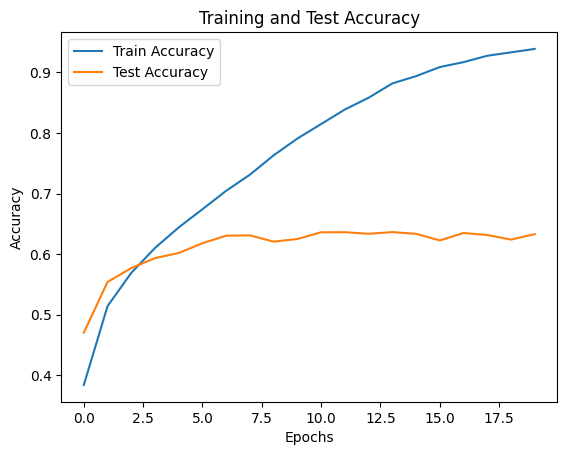

In [216]:
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

##### Visualize Predictions

In [217]:
def predictAndPlotGrid(model, dataset, classes, gridSize=3):
  model.eval()
  fix, axes = plt.subplots(gridSize, gridSize, figsize=(9, 9))
  for i in range(gridSize):
    for j in range(gridSize):
      idx = random.randint(0, len(dataset) - 1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)
      img = img / 2 + 0.5 # unnormalize images to be able to plot them with matplotlib
      npimg = img.cpu().numpy()
      axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = "g"
      else:
        color = "r"
      axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
      axes[i, j].axis("off")
  plt.tight_layout()
  plt.show()

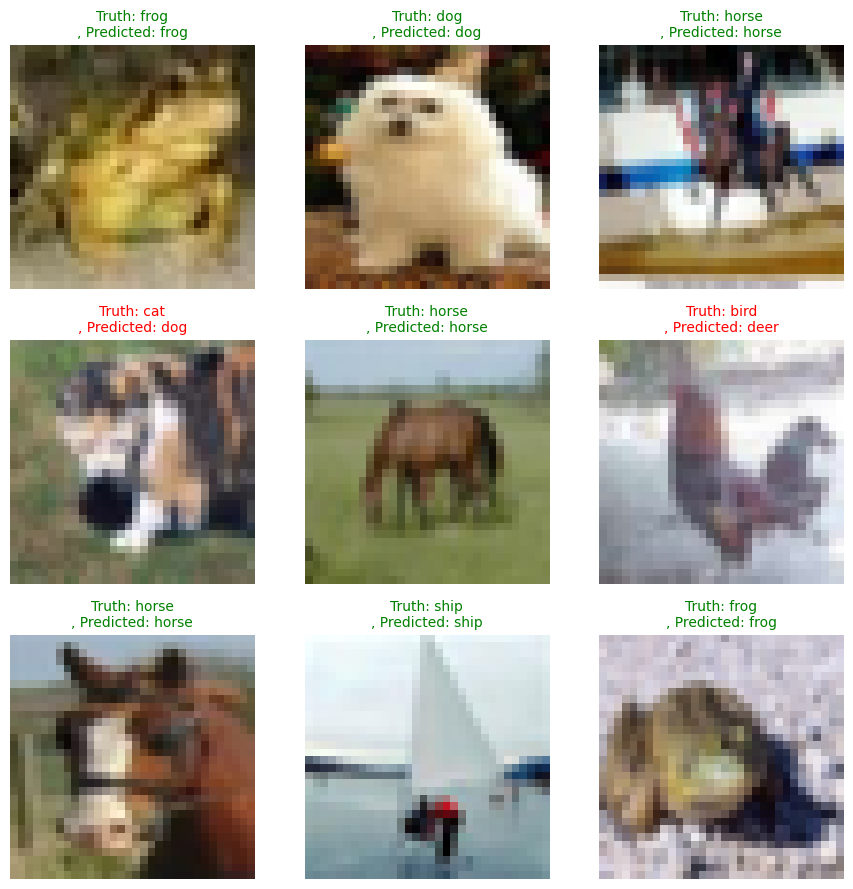

In [220]:
predictAndPlotGrid(model, test_dataset, classes=train_dataset.classes, gridSize=3)